Loading required files.

In [ ]:
import pandas as pd
import numpy as np
from keras.models import load_model

links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')

Cleaning genres string. Replacing "|" with " " and replacing null with blank string.

In [0]:
tags_1 = pd.DataFrame(tags.groupby('movieId')['tag'].apply(lambda x: "%s" % ' '.join(x)))
df = pd.merge(movies, tags_1,on='movieId', how='left')
df['genres'] = df['genres'].str.replace('|',' ')
df.fillna("",inplace=True)

Label Encoding "movieId" column so that the movieId's start with 1 and end with 9742 (max number of movies in the dataset).

In [0]:
from sklearn.preprocessing import LabelEncoder
item_enc = LabelEncoder()

df['movieId'] = item_enc.fit_transform(df['movieId'].values)

df['movieId'] = df['movieId']+1

Converting upper case characters to lower case. To avoid duplicates when the words are tokenized.

In [0]:
df.genres = df.genres.apply(lambda x: x.lower())

In [0]:
import string
df.genres = df.genres.apply(lambda x: x.translate(string.punctuation))
df.tag = df.tag.apply(lambda x: x.translate(string.digits))

In [0]:
ratings['movieId'] = item_enc.fit_transform(ratings['movieId'].values)

ratings['movieId'] = ratings['movieId']+1


Grouping movies by userId.

In [0]:
user_movies_watched = pd.DataFrame(ratings.groupby(['userId']).apply(lambda x: [list(x['movieId'])]).apply(pd.Series))

In [0]:
user_movies_watched.head(3)

,0
userId,
1,"[1, 3, 6, 44, 47, 63, 90, 98, 125, 131, 137, 1..."
2,"[278, 292, 1284, 2671, 4608, 5295, 6237, 6299,..."
3,"[31, 462, 546, 566, 586, 657, 697, 832, 853, 9..."


In [0]:
user_movies_watched.columns = ['movies']

Obtaining a single long list which has all the movies seen by every user.

In [0]:
movies_all = user_movies_watched.movies.values
movies_all = [item for sublist in movies_all for item in sublist]

In [0]:
# best to have a sequence size of 36: as 100836/36 is divisible

Will be creating a sequence of 36 movies (which will be our movie Input)

In [0]:
maxlen = 36 
step = 36
movies_list = []
for i in range(0, len(movies_all) - maxlen, step):
    movies_list.append(movies_all[i: i + maxlen])

Lets obtain the corresponding genres.

In [0]:
master_genre = []
for i in movies_list:
    hi= ""
    for j in i:
        hi = hi+df.loc[df['movieId'] == j, 'genres'].iloc[0]
        hi = hi+" "
    master_genre.append([hi])

Single long string to list of words.

In [0]:
for i in range(0,len(master_genre)):
    master_genre[i]=master_genre[i][0].split(" ")

In [0]:
final_master_genre = []
for i in master_genre:
    final_master_genre.append(list(filter(None, i)))
result = list(set(x for l in final_master_genre for x in l))

Tokenizing all the genres. Every word will have a unique number associated with it.

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_num_word = 100 #max size of library
tokenizer = Tokenizer(num_words=max_num_word)
tokenizer.fit_on_texts(list(result))
list_tokenized_train = tokenizer.texts_to_sequences(list(final_master_genre))
genres_map = dict(map(reversed, tokenizer.word_index.items()))
genres_array = pad_sequences(list_tokenized_train,maxlen=129, padding='post')

#if the library ends up smaller then the max size, update the info
if len(tokenizer.word_index) < max_num_word:
    max_num_word = len(tokenizer.word_index)
    
print('Number of words:', max_num_word)
max_size_array = max(len(l) for l in master_genre)

Number of words: 24


One hot encoded outputs corresponding the movie inputs.

In [0]:
y = np.zeros((2800, 9743))
def y_s(j,row):
    for i in row:
        y[j,i]=1

for i in range(0,2800):
    y_s(i,movies_list[i])

The deep learning model.

In [0]:
from keras.layers import Concatenate, Dense, Dropout, Flatten, LSTM
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Add, Activation, Lambda
#from keras.backend import K

n_factors = 256

def rec(n_factors):
    
    movies = Input(shape=(36,))
    m = Embedding(9743, n_factors)(movies)
    m = Flatten()(m)
    
    genres = Input(shape=(129,))
    g = Embedding(25, n_factors)(genres)
    g = Flatten()(g)
    #g = Reshape((n_factors,))(g)
    
    
    x = Concatenate()([m, g])
    x = Dropout(0.05)(x)
    x = Reshape((1,42240))(x)
#     x = Dense(100, kernel_initializer='he_normal')(x)
#     x = Activation('sigmoid')(x)
#     x = Dropout(0.5)(x)
#     x = Reshape((1,100))(x)
    
    x = LSTM(256, dropout=0.2, recurrent_dropout=0.2) (x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    
    x = Dense(9743, kernel_initializer='he_normal')(x)
    x = Activation('softmax')(x)
    
    model = Model(inputs=[movies, genres], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [0]:
model = rec(256)
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 36)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 129)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 36, 256)      2494208     input_1[0][0]                    
__________________________________________________________________________

Train.

In [0]:
history = model.fit(x=[movies_list, genres_array], y=y, batch_size=16, epochs=2000,
                    verbose=2)

Epoch 1/2000
 - 5s - loss: 0.0217 - acc: 0.9963
Epoch 2/2000
 - 5s - loss: 0.0210 - acc: 0.9963
Epoch 3/2000
 - 5s - loss: 0.0204 - acc: 0.9963
Epoch 4/2000
 - 5s - loss: 0.0199 - acc: 0.9963
Epoch 5/2000
 - 5s - loss: 0.0194 - acc: 0.9963
Epoch 6/2000
 - 5s - loss: 0.0190 - acc: 0.9963
Epoch 7/2000
 - 5s - loss: 0.0186 - acc: 0.9963
Epoch 8/2000
 - 5s - loss: 0.0182 - acc: 0.9963
Epoch 9/2000
 - 5s - loss: 0.0179 - acc: 0.9963
Epoch 10/2000
 - 5s - loss: 0.0176 - acc: 0.9963
Epoch 11/2000
 - 5s - loss: 0.0173 - acc: 0.9963
Epoch 12/2000
 - 5s - loss: 0.0171 - acc: 0.9963
Epoch 13/2000
 - 5s - loss: 0.0169 - acc: 0.9963
Epoch 14/2000
 - 5s - loss: 0.0167 - acc: 0.9963
Epoch 15/2000
 - 5s - loss: 0.0165 - acc: 0.9963
Epoch 16/2000
 - 5s - loss: 0.0164 - acc: 0.9963
Epoch 17/2000
 - 5s - loss: 0.0162 - acc: 0.9963
Epoch 18/2000
 - 5s - loss: 0.0161 - acc: 0.9963
Epoch 19/2000
 - 5s - loss: 0.0160 - acc: 0.9963
Epoch 20/2000
 - 5s - loss: 0.0159 - acc: 0.9963
Epoch 21/2000
 - 5s - loss: 0

In [0]:
model.save('gdrive/My Drive/better1.h5')

Loss over time (or epochs). Steady decrease.

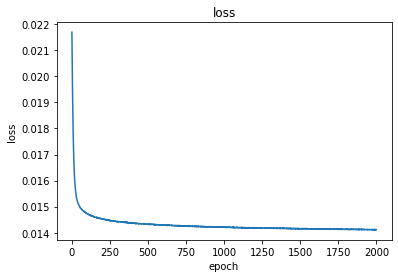

In [0]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [0]:
history = model.fit(x=[movies_list, genres_array], y=y, batch_size=16, epochs=1000,
                    verbose=2)

Epoch 1/1000
 - 5s - loss: 0.0141 - acc: 0.9963
Epoch 2/1000
 - 5s - loss: 0.0141 - acc: 0.9963
Epoch 3/1000
 - 5s - loss: 0.0141 - acc: 0.9963
Epoch 4/1000
 - 5s - loss: 0.0141 - acc: 0.9963
Epoch 5/1000
 - 5s - loss: 0.0141 - acc: 0.9963
Epoch 6/1000
 - 5s - loss: 0.0141 - acc: 0.9963
Epoch 7/1000
 - 5s - loss: 0.0141 - acc: 0.9963
Epoch 8/1000
 - 5s - loss: 0.0141 - acc: 0.9963
Epoch 9/1000
 - 5s - loss: 0.0141 - acc: 0.9963
Epoch 10/1000
 - 5s - loss: 0.0141 - acc: 0.9963
Epoch 11/1000
 - 5s - loss: 0.0141 - acc: 0.9963
Epoch 12/1000
 - 5s - loss: 0.0141 - acc: 0.9963
Epoch 13/1000
 - 5s - loss: 0.0141 - acc: 0.9963
Epoch 14/1000
 - 5s - loss: 0.0141 - acc: 0.9963
Epoch 15/1000
 - 5s - loss: 0.0141 - acc: 0.9963
Epoch 16/1000
 - 5s - loss: 0.0141 - acc: 0.9963
Epoch 17/1000
 - 5s - loss: 0.0141 - acc: 0.9963
Epoch 18/1000
 - 5s - loss: 0.0141 - acc: 0.9963
Epoch 19/1000
 - 5s - loss: 0.0141 - acc: 0.9963
Epoch 20/1000
 - 5s - loss: 0.0141 - acc: 0.9963
Epoch 21/1000
 - 5s - loss: 0

In [0]:
model.save('gdrive/My Drive/better2.h5')

To provide custom inputs.

In [0]:
def prepare_inputs(movie_input):
    """
    With only MovieID's as the input to our model, we are required to 
    obtain the required genre's and tag's and bring our raw input to
    the required shape.
    """
    
    movies_copy = movie_input[:]

    genres = (DF.genres[DF["movieId"].isin(movie_input)].values).tolist()
    genres = [word for line in genres for word in line.split()]

    genres = [
        list(GENRES_MAP.keys())[list(GENRES_MAP.values()).index(i)] for i in genres
    ]
    
    genres = pad(genres, INPUT_LENGTH["genre_len"])    
    movie_input = pad(movie_input, INPUT_LENGTH["movie_len"])
    
    return movie_input, genres, movies_copy
        
movies, g_input, movie_copy = prepare_inputs([508,597])

Predict

In [0]:
p = model.predict([np.array([movie_input,]),np.array([g_input,])])

Recommended movies

In [0]:
most_similar = preds[0].argsort()[-(10 + len(movie_copy)) :][::-1]
rec_movies = DF.set_index("movieId").loc[most_similar].reset_index()    
blankIndex=[''] * len(rec_movies)
rec_movies.index=blankIndex
rec_movies

,movieId,Title,Genres,Tags
0,2900,Bring It On (2000),comedy,
1,2904,Nurse Betty (2000),comedy crime drama romance thriller,
2,3000,"Dude, Where's My Car? (2000)",comedy sci-fi,bad
3,3013,Dracula 2000 (2000),horror,
4,3007,Cast Away (2000),drama,
5,2963,"Private Eyes, The (1981)",comedy mystery,
6,2965,Book of Shadows: Blair Witch 2 (2000),crime horror mystery thriller,
7,2937,Slumber Party Massacre II (1987),horror,
8,2941,Bamboozled (2000),comedy,
9,2756,"Toxic Avenger, The (1985)",comedy horror,


In [0]:
import pickle
with open('gdrive/My Drive/genres_map.pickle', 'wb') as handle:
    pickle.dump(genres_map, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
genres_map

{1: 'imax',
 2: 'war',
 3: 'documentary',
 4: 'crime',
 5: 'drama',
 6: 'romance',
 7: 'thriller',
 8: 'film',
 9: 'noir',
 10: 'mystery',
 11: 'fantasy',
 12: 'children',
 13: 'adventure',
 14: 'horror',
 15: 'animation',
 16: 'action',
 17: 'sci',
 18: 'fi',
 19: 'genres',
 20: 'no',
 21: 'listed',
 22: 'western',
 23: 'comedy',
 24: 'musical'}